# <center> Дипломный проект <br> Анализ тональности отзывов <br>

## <center> Соревнование по сентимент-анализу (простая версия)

В этом соревновании необходимо прогнозировать по тексту отзыва его тональность: 1 - позитивная, 0 - негативная. В отличие от усложненной версии задачи, здесь вам не требуется самостоятельно собирать обучающую выборку - она есть в предоставляемых вам данных.

https://inclass.kaggle.com/c/product-reviews-sentiment-analysis-light

### Загрузка модулей

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, SGDClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score, GridSearchCV
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import pickle

In [2]:
import warnings
warnings.filterwarnings('ignore')

### Загрузка данных 

In [3]:
train_data = pd.read_table('data/products_sentiment_train.tsv', header=None, names=['text','label'])
label = train_data.label
train_data = train_data.text
train_data.head(2)

0            2 . take around 10,000 640x480 pictures .
1    i downloaded a trial version of computer assoc...
Name: text, dtype: object

In [4]:
test_data = pd.read_table('data/products_sentiment_test.tsv', index_col=0)
test_data = test_data.text
test_data.head(2)

Id
0    so , why the small digital elph , rather than ...
1    3/4 way through the first disk we played on it...
Name: text, dtype: object

Посмотрим на предложения:

In [5]:
train_data[1000]

"if you 've been listening to cd 's in your car for awhile , dealing with the drop-off in sound quality may take some getting used to ."

Ничего не обычного.

### Распределение классов

In [6]:
print(f'Размер обучающей выборки: {len(label)}')
print(f'Положительных отзывов: {sum(label)}')
print(f'Отрицательных отзывов: {len(label) - sum(label)}')

Размер обучающей выборки: 2000
Положительных отзывов: 1274
Отрицательных отзывов: 726


Распределение неидеальное, это можно учесть при оптимизации.

## Baseline

In [7]:
def testing_model(model, vectorizer):
    pipepline = make_pipeline(vectorizer, model)
    score = cross_val_score(pipepline, train_data, label,scoring='accuracy', cv=5, n_jobs=-1)
    return score.mean()

In [8]:
def answer_to_kaggle(predict, file_name):
    answer = ['id,y']
    for i in range(len(test_data.index)):
        answer.append(f'{i},{predict[i]}')
    with open(file_name, 'w') as f:
        f.write('\n'.join(answer))

In [9]:
def plot_validation_curves(param_values, grid_cv_results_):
    train_mu, train_std = grid_cv_results_['mean_train_score'], grid_cv_results_['std_train_score']
    valid_mu, valid_std = grid_cv_results_['mean_test_score'], grid_cv_results_['std_test_score']
    train_line = plt.plot(param_values, train_mu, '-', label='train', color='green')
    valid_line = plt.plot(param_values, valid_mu, '-', label='test', color='red')
    plt.fill_between(param_values, train_mu - train_std, train_mu + train_std, edgecolor='none',
                     facecolor=train_line[0].get_color(), alpha=0.2)
    plt.fill_between(param_values, valid_mu - valid_std, valid_mu + valid_std, edgecolor='none',
                     facecolor=valid_line[0].get_color(), alpha=0.2)
    plt.legend()

### Классификаторы

Сравним разные классификаторы

In [10]:
testing_model(LogisticRegression(), CountVectorizer())

0.7684956843480272

In [11]:
testing_model(LinearSVC(), CountVectorizer())

0.754000653129082

In [12]:
testing_model(SGDClassifier(), CountVectorizer())

0.738984368652304

Самое высокое качество на LogisticRegression.

###  TfidfVectorizer

In [13]:
testing_model(LogisticRegression(), TfidfVectorizer())

0.7665031843949025

Качество с TfidfVectorizer почти не изменилось.

### df_min

In [14]:
testing_model(LogisticRegression(), CountVectorizer(min_df=10))

0.750524400152501

In [15]:
testing_model(LogisticRegression(), CountVectorizer(min_df=50))

0.7150017812611329

Оставим min_df по умолчанию (min_df=1).

### Стоп-слова

Попробуем добавить стоп-слова из модуля nltk  и sklearn

In [25]:
stopwords = nltk.corpus.stopwords.words('english')

In [17]:
testing_model(LogisticRegression(), CountVectorizer(stop_words=stopwords))

0.7540043687773048

In [18]:
testing_model(LogisticRegression(), CountVectorizer(stop_words='english'))

0.7469993812461327

Со стоп-словами качество уменьшилось.

### Биграммы

In [19]:
testing_model(LogisticRegression(), CountVectorizer(ngram_range=(1,2)))

0.7705044437777736

In [20]:
testing_model(LogisticRegression(), CountVectorizer(ngram_range=(1,3)))

0.7665106656916605

In [21]:
testing_model(LogisticRegression(), CountVectorizer(ngram_range=(3,5), analyzer='char_wb'))

0.7594968874805467

Будем использовать ngram_range = (1,2)

В итоге у нас получилась следующая модель:

In [22]:
clf_baseline = make_pipeline(CountVectorizer(ngram_range=(1,2)), LogisticRegression())

In [23]:
%%time
clf_baseline.fit(train_data, label)
predict_baseline = clf_baseline.predict(test_data)
answer_to_kaggle(predict_baseline, 'baseline.csv')

CPU times: user 365 ms, sys: 6.47 ms, total: 372 ms
Wall time: 259 ms


Получили результат: 0.8150

Ushakov Vadim

# Повышение качества

### GribSearch

Сделаем тоже самое перебором с помощью GridSearcheCV:

In [22]:
pipe = Pipeline([('vectorizer', CountVectorizer()), ('classifier', LogisticRegression())])

In [28]:
param_grid = [
    {'classifier': [LogisticRegression(class_weight='balanced'), LinearSVC(class_weight='balanced')], 
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'vectorizer__min_df': [1, 2, 10, 50],
    'vectorizer__max_df': np.linspace(0.1, 1, 10),
    'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
    'vectorizer__analyzer':['word'],
    'vectorizer__stop_words': [None, 'english', stopwords]},
    {'classifier': [LogisticRegression(class_weight='balanced'), LinearSVC(class_weight='balanced')], 
    'vectorizer': [CountVectorizer(), TfidfVectorizer()],
    'vectorizer__min_df': [1, 2, 10, 50],
    'vectorizer__max_df': np.linspace(0.1, 1, 10),
    'vectorizer__ngram_range': [(3,5)],
    'vectorizer__analyzer':['char_wb'],
    'vectorizer__stop_words': [None, 'english', stopwords]}
]

In [29]:
grid = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1)

In [ ]:
%%time
grid.fit(train_data, label)
print(grid.best_params_)

In [29]:
print(grid.best_score_)

0.7905


Как оказалось, комбинация LinearSVC и TfidVectorizer(ngram_range=(1,3)) более выиграшная.

Попробуем оптимизировать параметр С у LinearSVC:

In [39]:
%%time
pipe = Pipeline([('vectorizer', TfidfVectorizer(binary=True, max_df=0.218, ngram_range=(1,3))), 
                 ('classifier', LinearSVC(class_weight='balanced'))])
param_C = {'classifier__C': np.linspace(1e-4, 10, 100)}
grid = GridSearchCV(pipe, param_C, cv=5, n_jobs=-1)
grid.fit(train_data, label)

CPU times: user 2.04 s, sys: 140 ms, total: 2.18 s
Wall time: 43.9 s


In [40]:
print(grid.best_params_)
print(grid.best_score_)

{'classifier__C': 1.1112}
0.7915


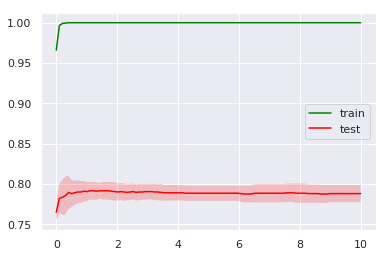

In [41]:
plot_validation_curves(np.linspace(1e-4, 10, 100), grid.cv_results_)

Качество несколько повысилось

In [47]:
predict_SVM_Tfid = grid.predict(test_data)
answer_to_kaggle(predict_SVM_Tfid, 'SVM_TFid.csv')

Получили результат: 0.83750

Попробуем более экзотические способы:

### Лемматизация

In [38]:
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [49]:
param_grid_lemma = [
    {'vectorizer__tokenizer': [LemmaTokenizer()],
    'classifier': [LinearSVC(class_weight='balanced')],
    'vectorizer': [TfidfVectorizer(ngram_range=(1,3))],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]}]

In [50]:
pipe = Pipeline([('vectorizer', CountVectorizer()), ('classifier', LogisticRegression())])

In [51]:
grid_lemma = GridSearchCV(pipe, param_grid_lemma, cv=5, n_jobs=-1)

In [52]:
%%time
grid_lemma.fit(train_data, label)
print(grid_lemma.best_params_)

{'classifier': LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0), 'classifier__C': 1, 'vectorizer': TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<__main__.LemmaTokenizer object at 0x7f47a53b5f60>,
        use_idf=True, vocabulary=None), 'vectorizer__tokenizer': <__main__.LemmaTokenizer object at 0x7f47a53b5f60>}
CPU times: user 1.13 s, sys: 95.6 ms, total: 1.22 s
Wall time: 11 s


In [53]:
print(grid_lemma.best_score_)

0.8035


На кроссвалидации качество повысилось, посмотрим на kaggle:

In [54]:
predict_lemma = grid_lemma.predict(test_data)
answer_to_kaggle(predict_lemma, 'lemma.csv')

Получили результат: 0.81750, что хуже предыдущей модели.

В итоге остановимся на комбинации LinearSVC и TfidVectorizer

Спасибо за просмотр!